In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import pickle
import torch
import io
import random
from gensim.models import Word2Vec

In [2]:
# function to work around loading a GPU generated pickle on local CPU machine
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# load synthesizer from saved object
with open('models/TVAE_synthesizer_10emb_noCat.pkl', 'rb') as input:
    synthesizer = CPU_Unpickler(input).load()

# modify device from cuda:0 to cpu
synthesizer.device = 'cpu'

In [4]:
# load synthesizer from local machine
#with open('models/TVAE_synthesizer_test.pkl', 'rb') as input:
#    synthesizer = pickle.load(input)

In [5]:
# check out sample
N = 100000
sample = synthesizer.sample(N)
np.set_printoptions(suppress = True, precision = 2)

In [6]:
df_input = pd.read_csv('data/cc_data_input_10emb.csv')

In [7]:
input_columns = list(df_input.columns)[1:]

In [8]:
df_sample = pd.DataFrame(sample, columns=input_columns) 
pd.set_option('display.max_columns', 36)
df_sample.head()

,Purchase Amount,Age,Account Type_bank_account,Account Type_credit_card,Consumer Gender_female,Consumer Gender_male,SIC Description_Book Stores,"SIC Description_Communications Services, Not Elsewhere Classified",SIC Description_Drug Stores and Proprietary Stores,SIC Description_Eating Places,SIC Description_Family Clothing Stores,SIC Description_Gasoline Service Stations,SIC Description_Grocery Stores,SIC Description_Miscellaneous Food Stores,SIC Description_Other,SIC Description_Taxicabs,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,period_of_month_end,period_of_month_mid,period_of_month_start,retailerVec_01,retailerVec_02,retailerVec_03,retailerVec_04,retailerVec_05,retailerVec_06,retailerVec_07,retailerVec_08,retailerVec_09,retailerVec_10
0,0.763579,30.517282,0.999993,0.000009,0.000210,0.999965,0.000016,-0.000012,-0.000016,1.000015,0.000058,-0.000064,-0.000019,-0.000066,6.020757e-07,0.000036,-0.000068,0.000090,-0.000067,-0.000010,0.000016,0.000036,-0.000003,1.270615e-05,0.000018,-0.000010,0.617872,-2.298235,0.417469,0.314528,-1.239116,-0.006567,-0.861837,-0.830861,0.192149,-0.405912
1,61.659183,26.500934,-0.000118,1.000066,0.999984,0.000011,0.000012,-0.000019,0.999981,0.000023,0.000031,0.000026,0.000036,-0.000007,-5.726761e-05,0.000001,0.000011,-0.000023,0.000005,-0.000011,0.000051,-0.000037,0.000023,-7.965863e-05,-0.000029,0.000118,1.503592,-0.659627,-0.766272,1.453168,-0.320445,-1.973250,-0.232675,-2.488090,-1.812435,0.070617
2,41.136085,42.359102,1.000002,0.000037,0.999987,-0.000064,0.000048,0.000035,-0.000033,0.000049,0.000061,0.000034,0.000002,0.000041,1.538842e-05,0.000044,0.000033,-0.000014,0.000013,0.000029,-0.000044,0.000004,0.000033,2.514900e-05,0.000039,-0.000056,-0.357457,-0.408413,-1.354157,1.202141,-0.641563,-2.373387,-0.964445,-3.080626,-2.249861,-0.675948
3,61.141709,27.128751,1.000016,0.000032,0.999997,0.000005,-0.000034,0.000023,-0.000011,0.000017,-0.000046,0.000025,1.000005,-0.000014,-3.241537e-05,0.000014,0.000074,-0.000006,0.000024,0.000059,-0.000010,0.000044,-0.000006,4.771604e-05,0.000041,-0.000062,0.004982,-0.630837,-0.735150,-0.240784,0.490366,-1.782015,-0.587271,-1.114815,-0.338842,-1.115199
4,11.834146,27.872163,0.000014,1.000063,0.000021,0.999988,0.000018,-0.000009,-0.000012,-0.000036,-0.000004,1.000063,-0.000005,-0.000031,-1.036467e-04,-0.000010,0.000031,0.000010,-0.000023,0.000011,0.000021,0.000003,-0.000012,8.052389e-07,0.000114,-0.000045,1.678872,-0.736867,-1.951804,1.862181,-0.415641,-2.570078,-0.458733,-2.708580,-1.936517,-0.171808


In [9]:
# return series of dummy variables with given column name
def reverse_dummy(df, col_name):
    # get index of columns that starts with col_name, for example, Gender_male, Gender_female for col_name = `Gender`
    idx = [i for i, s in enumerate(list(df.columns)) if col_name in s]
    tmp = df.iloc[:,idx]
    # find column name for max in each row and put into one series
    df_output = pd.Series(tmp.idxmax(axis=1), name = col_name)
    
    # remove strings with col_name plus underscore
    df_output = df_output.map(lambda x: x.replace(col_name + '_',''))
    return df_output

In [10]:
df_num = df_sample.iloc[:,[0,1]]
df_account = reverse_dummy(df_sample,'Account Type')
df_gender = reverse_dummy(df_sample,'Consumer Gender')
df_SIC = reverse_dummy(df_sample,'SIC Description')
df_dw = reverse_dummy(df_sample,'day_of_week')
df_pm = reverse_dummy(df_sample,'period_of_month')

In [11]:
df_reverse = pd.concat([df_num,df_account,df_gender,df_SIC,df_dw,df_pm], axis=1)

# round age column
df_reverse['Age'] = df_reverse['Age'].apply(lambda x: round(x, 0))

# remove negative purchase amount
df_reverse = df_reverse[(df_reverse['Purchase Amount'] > 0)]
df_reverse.reset_index(drop=True, inplace=True)

#pd.set_option('display.max_rows', N)
print(df_reverse.shape)
df_reverse.head()

(97405, 7)


,Purchase Amount,Age,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month
0,0.763579,31.0,bank_account,male,Eating Places,Monday,mid
1,61.659183,27.0,credit_card,female,Drug Stores and Proprietary Stores,Thursday,start
2,41.136085,42.0,bank_account,female,Family Clothing Stores,Wednesday,mid
3,61.141709,27.0,bank_account,female,Grocery Stores,Friday,end
4,11.834146,28.0,credit_card,male,Gasoline Service Stations,Friday,mid


In [12]:
#df_reverse['SIC Description'].value_counts().index.to_list()

In [13]:
# reverse retailerVec back to retailers
idx = [i for i, s in enumerate(list(df_sample.columns)) if 'retailerVec' in s]
df_retailerVec = df_sample.iloc[:,idx]

# load the retailer_map
with open('models/retailer_map.pkl', 'rb') as input:
    retailer_map = pickle.load(input)    

model = Word2Vec.load('models/perSICperPerson_10emb.model')
    
# only keep values in the model (more than 5 times appearance)
for key, value in retailer_map.items():
    retailer_map[key] = list(set(value) & set(model.wv.vocab))
    
# group other SIC (after top N) into other
list2keep = ['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Drug Stores and Proprietary Stores', 'Miscellaneous Food Stores', 'Family Clothing Stores', 'Taxicabs', 'Communications Services, Not Elsewhere Classified']
other_list = []    
for key, value in retailer_map.items():
    if key not in list2keep:
        other_list = other_list + value

# delete other group key-values in retailer_map
retailer_map_grouped = {k: retailer_map[k] for k in list2keep}

# add other key-value pairs
retailer_map_grouped['Other'] = other_list

# put retailer vectors into one column
df_retailerVec['retailerVec']= df_retailerVec.values.tolist()
df_SIC_vector = pd.concat([df_SIC,df_retailerVec['retailerVec']],axis = 1)
df_SIC_vector.head()

d:\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SIC Description,retailerVec
0,Eating Places,"[0.617871797337524, -2.2982353138030174, 0.417..."
1,Drug Stores and Proprietary Stores,"[1.503592375922174, -0.6596274566173681, -0.76..."
2,Family Clothing Stores,"[-0.3574567862460155, -0.40841332455143664, -1..."
3,Grocery Stores,"[0.004981666678623841, -0.630837057471089, -0...."
4,Gasoline Service Stations,"[1.6788722430006593, -0.7368671480435515, -1.9..."


In [14]:
retailer_map_grouped.keys()
#retailer_map_grouped['Radiotelephone Communications']
#df_SIC_vector['SIC Description'].value_counts()

dict_keys(['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Drug Stores and Proprietary Stores', 'Miscellaneous Food Stores', 'Family Clothing Stores', 'Taxicabs', 'Communications Services, Not Elsewhere Classified', 'Other'])

In [15]:
# find out retailer in the same SIC and also with the most similar vector
def return_retailer_SIC(model, retailer_map_grouped, sector, vector):
    if pd.isnull(sector):
        return None
    else:
        word_list = retailer_map_grouped[sector]
        min_idx = model.wv.distances(vector, other_words = word_list).argmin()
        return word_list[min_idx]

In [16]:
df_reverse['Normalized Retailer'] = df_SIC_vector.apply(lambda x: return_retailer_SIC(model, retailer_map_grouped, x['SIC Description'],x['retailerVec']), axis = 1)
df_reverse.head()

,Purchase Amount,Age,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Normalized Retailer
0,0.763579,31.0,bank_account,male,Eating Places,Monday,mid,Kramer's
1,61.659183,27.0,credit_card,female,Drug Stores and Proprietary Stores,Thursday,start,Pharma Sense
2,41.136085,42.0,bank_account,female,Family Clothing Stores,Wednesday,mid,Abercrombie Kids
3,61.141709,27.0,bank_account,female,Grocery Stores,Friday,end,Walmart
4,11.834146,28.0,credit_card,male,Gasoline Service Stations,Friday,mid,Petro-Canada


In [17]:
# given period_of_month (start, mid or end) and year (1989) and month (6), return index of the possible days
def return_day_index(period_of_month, year, month):
    if period_of_month == 'start':
        return list(range(1,11))
    elif period_of_month == 'mid':
        return list(range(11,21))
    else:
        return list(range(21, pd.Period(str(year) + '-' + str(month)).days_in_month + 1))
    
# function to convert day_of_week and period_of_month back to Date, given a year and a month
# Example:
# input: day_of_week = 'Monday'; period_of_month = 'start'; Y = 2020; M = 2
# output: 2020-02-03 00:00:00

def return_date(day_of_week, period_of_month, Y, M):
    # return list of days
    D = return_day_index(period_of_month, Y, M)

    tmp = pd.DataFrame({'year': [str(Y) for i in range(len(D))],
                        'month': [str(M) for i in range(len(D))],
                        'day': D})
    
    # create table with each row of year, month and day in given period
    date_period = pd.to_datetime(tmp[['year', 'month', 'day']])

    # locate index of which date is the given day_of_week
    idx_list = [i for i, s in enumerate(date_period.dt.strftime('%A')) if day_of_week in s]

    # randomly pick up one index, since it's possible one period has multiple given weekday (say Monday)
    idx = random.choice(idx_list)

    return date_period[idx]

In [18]:
Y = 2022; M = 2
df_reverse['Transaction Date'] = df_reverse.apply(lambda x: return_date(x.day_of_week, x.period_of_month, Y, M), axis = 1)
#df_reverse.drop(['day_of_week','period_of_month'], axis = 1, inplace = True, errors = 'ignore')
df_reverse.head()

,Purchase Amount,Age,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Normalized Retailer,Transaction Date
0,0.763579,31.0,bank_account,male,Eating Places,Monday,mid,Kramer's,2022-02-14
1,61.659183,27.0,credit_card,female,Drug Stores and Proprietary Stores,Thursday,start,Pharma Sense,2022-02-10
2,41.136085,42.0,bank_account,female,Family Clothing Stores,Wednesday,mid,Abercrombie Kids,2022-02-16
3,61.141709,27.0,bank_account,female,Grocery Stores,Friday,end,Walmart,2022-02-25
4,11.834146,28.0,credit_card,male,Gasoline Service Stations,Friday,mid,Petro-Canada,2022-02-11


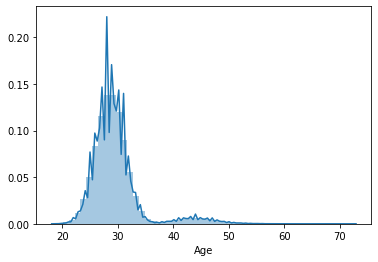

In [19]:
sns.distplot(df_reverse['Age']);

In [20]:
# view counts and percentage for each column's elements
def view_column_counts(df, col_name):
    df_pivot = df.groupby(by = col_name).size().reset_index(name='Counts')
    df_pivot['Per (%)'] = (df_pivot['Counts'])/df.shape[0]*100
    df_pivot.sort_values(by = 'Counts',ascending = False,inplace = True)
    return df_pivot

In [21]:
# gender, account type, sector and retailer percentage
text_col_list = ['Account Type', 'Consumer Gender','Normalized Retailer', 'SIC Description']

for col_name in text_col_list:   
    print(col_name)
    df_pivot = view_column_counts(df_reverse,col_name)
    print(df_pivot)
    print('\n')

Account Type
   Account Type  Counts   Per (%)
0  bank_account   52509  53.90791
1   credit_card   44896  46.09209


Consumer Gender
  Consumer Gender  Counts    Per (%)
0          female   53913  55.349315
1            male   43492  44.650685


Normalized Retailer
     Normalized Retailer  Counts   Per (%)
1355         Tim Hortons    4045  4.152764
1174               Shell    2876  2.952621
1441             Walmart    2693  2.764745
819           McDonald's    2631  2.701093
1199              Sobeys    1770  1.817155
...                  ...     ...       ...
955          Pams Coffee       1  0.001027
953               Pacini       1  0.001027
929           Oh So Good       1  0.001027
928           Office Pub       1  0.001027
485        Gabriel Pizza       1  0.001027

[1508 rows x 3 columns]


SIC Description
                                     SIC Description  Counts    Per (%)
3                                      Eating Places   26609  27.317899
6                              

barplot for SIC Description


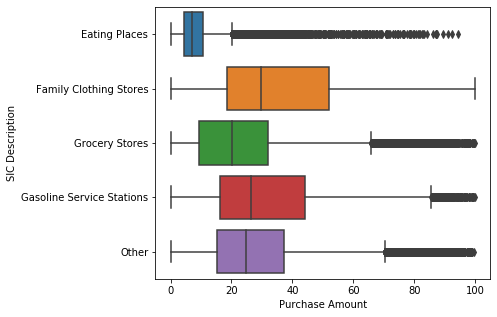

barplot for Normalized Retailer


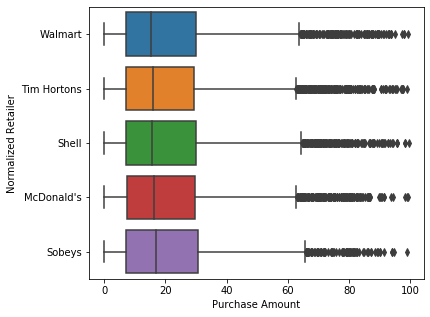

In [22]:
check_list = ['SIC Description','Normalized Retailer']
fig_dims = [6, 5] 
N = 5
threshold = 100

for cat in check_list:   
    print("barplot for %s" % (cat))
    list_tmp = df_reverse[cat].value_counts()[:N].index.tolist() # top N counts in that category
    df_tmp = df_reverse[df_reverse[cat].isin(list_tmp) & (df_reverse['Purchase Amount'] < threshold)]
    fig, ax = plt.subplots(figsize = fig_dims)
    chart = sns.boxplot(y = df_tmp[cat], x = df_tmp['Purchase Amount'])
    plt.show()